# Predictability of Player Subscription Status - DSCI 100 Project: Section 5 Group 31
By Jessica Ho, Justin Pilson, Ansen Chieng

# Introduction
We will be investigating the behaviour of people who play games using the dataset `players.csv` which was collected by Frank Wood's research group at UBC Computer Science from a MineCraft server that records each individual player's information. This information is collected to gain knowledge on how to go about player recruitment and the resources required to handle the amount of players.

From the `players.csv` dataset we are investigating, "Can age and hours played predict if a player has subscribed to the newsletter?" To have success in the gaming industry, it is important to prioritize player engagement and retention. One way to maintain engagement is through newsletter subscription. However, not all players subscribe to the newsletter, allowing for identification of factors that affect player subscription. Understanding trends of player variables can help tailor marketing strategies such as personalized outreach, to target specific players based on their behaviour.

The `players.csv` dataset represents different information of all players recorded in the dataset; the variables include:
- experience: How experienced the player is in MineCraft (Rank: Beginning, Amateur, Regular, Pro, Veteran), Type: character
- subscribe: Whether or not the player as subscribed to the game related newsletter (True or False), Type: logical
- hashedEmail: The email of each player converted into a string of different characters, Type: character
- played_hours: Amount of total hours played, Type: double
- name: The player's name, Type: character
- gender: The player's gender, Type: character
- Age: The player's age, Type: double

This results in a total of:
- 196 observations
- 7 variables

# Methods & Results

To answer our question, we will be using a $k$-NN classification model. This is because our goal is to predict what category, newsletter subscription status, each player belongs to based on their age and amount of hours played. We are assigning labels to each player, TRUE or FALSE if they are subscribed or not. A regression approach is not used as we are not trying to predict a numerical value. We will be basing our model on accuracy because there are no false positives or false negatives. We are only interested if the newsletter subscription status is predicted correctly or not. Therefore, recall and precision will not be useful for our model.

In [2]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


First, we input the dataset into our file. The data is pulled from an online url through github to ensure reproducibility across devices. We then use the `read_csv` file to pull the data file into R into a tibble so that we can perform our analysis.

In [3]:
set.seed(2000)
players.csv <- "https://raw.githubusercontent.com/justin-pilson/dsci-100-project-2025w2-group-31/refs/heads/main/players.csv"
players <- read_csv('players.csv')
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Next, we wrangle and tidy the data by eliminating unnecessary variables and ensuring the labels are consistently formatted. Since we are only looking at played_hours, age, and subscription status for our analysis, we will remove the rest. This step is not completely necessary to complete our model, however it simplifies the dataset making it easier to work with. We will also change 'Age' to 'age', for consistency. Other than this, the data is tidy and ready for analysis.

To change the name, we will use the `mutate` function. To eliminate the variables, we will use the `select` function.

In [4]:
players_simplified <- players |>
    mutate(age = Age) |>
    select(age, subscribe, played_hours)

players_simplified

age,subscribe,played_hours
<dbl>,<lgl>,<dbl>
9,TRUE,30.3
17,TRUE,3.8
17,FALSE,0.0
⋮,⋮,⋮
17,FALSE,0.0
17,FALSE,2.3
NA,TRUE,0.2


To further develop our understanding of the dataset, we will perform some summary statistics.

Firstly, we calculate the averages of both quantitative variables using `summarize`.

In [5]:
avg_played_hours <- players_simplified |>
    summarize(avg_hours = mean(played_hours)) |>
    pull()

avg_age <- players_simplified |>
    summarize(avg_age = mean(age, na.rm = TRUE)) |>
    pull()

averages <- tibble(avg_hours = round(avg_played_hours, 2), avg_age = round(avg_age, 2))
averages

avg_hours,avg_age
<dbl>,<dbl>
5.85,20.52


To help us discover patterns in the data before our analys, we create 3 summary plots:
- A bar graph showing the average hours by subscription status
- A histogram distribution of players' ages
- A scatterplot showing age vs. played hours, colouring the dots by subscription status

The bar graph first uses `group_by` and `summarize` to calculate the average hours played based on their subscription status. We then use `ggplot` to create the plot, classifying subscription status as *x* and average played hours as *y*. Next, we use `geom_bar`, classifying the *stat* argument as "identity" and adding a fill colour of #e87478 for aesthetic purposes. Finally, we add the x-label, y-label, and title using `labs` and change the text size using `theme`.

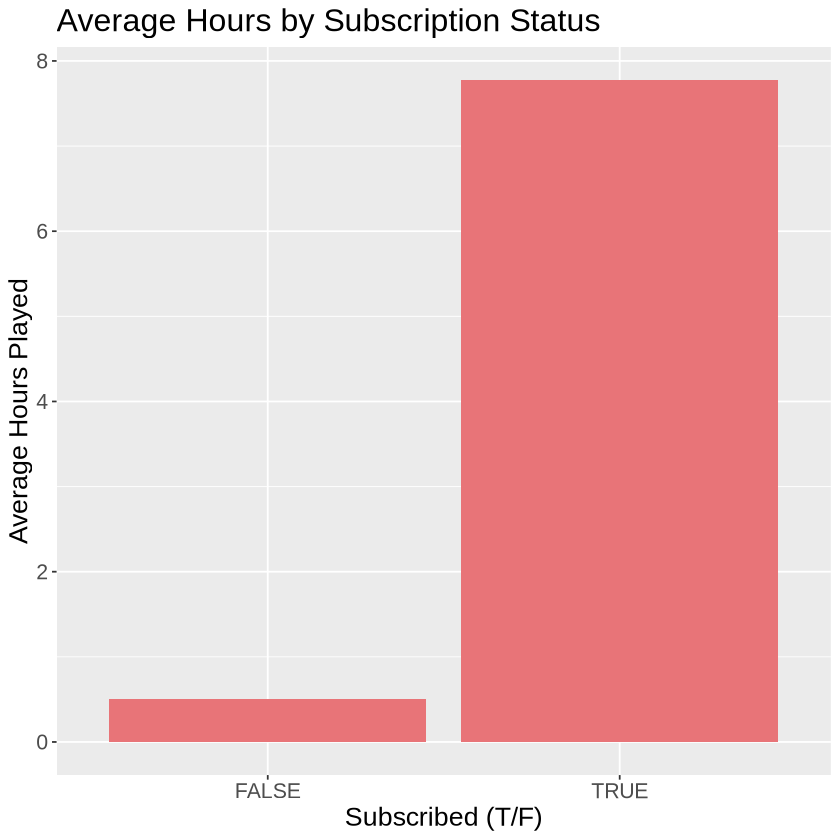

In [6]:
avg_hours_plot <- players_simplified |>
    group_by(subscribe) |>
    summarize(avg_hours = mean(played_hours)) |>
    ggplot(aes(x = subscribe, y = avg_hours)) +
        geom_bar(stat = "identity", fill = '#e87478') +  
        labs(title = 'Average Hours by Subscription Status', 
             x = 'Subscribed (T/F)', 
             y = 'Average Hours Played') +
        theme(text = element_text(size = 16))

avg_hours_plot

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


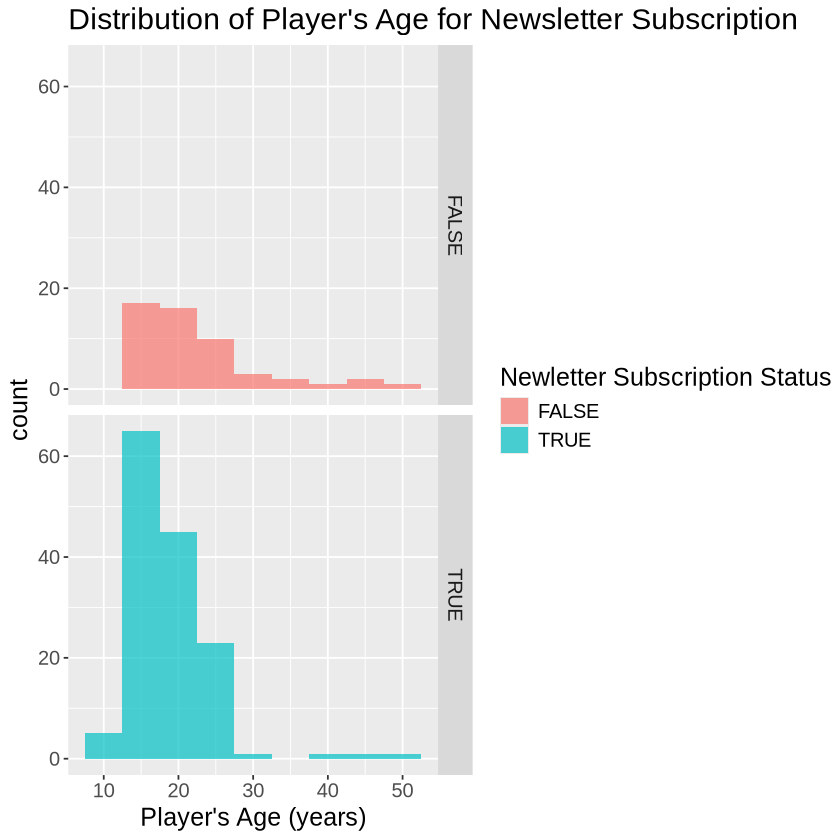

In [8]:
players_histogram <- players_simplified |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(binwidth = 5, position = "dodge", alpha = 0.7) +
    labs( x = "Player's Age (years)", fill = "Newletter Subscription Status",
         title = "Distribution of Player's Age for Newsletter Subscription") +
    facet_grid(rows = vars(subscribe)) +
    theme(text = element_text(size = 15))

players_histogram

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


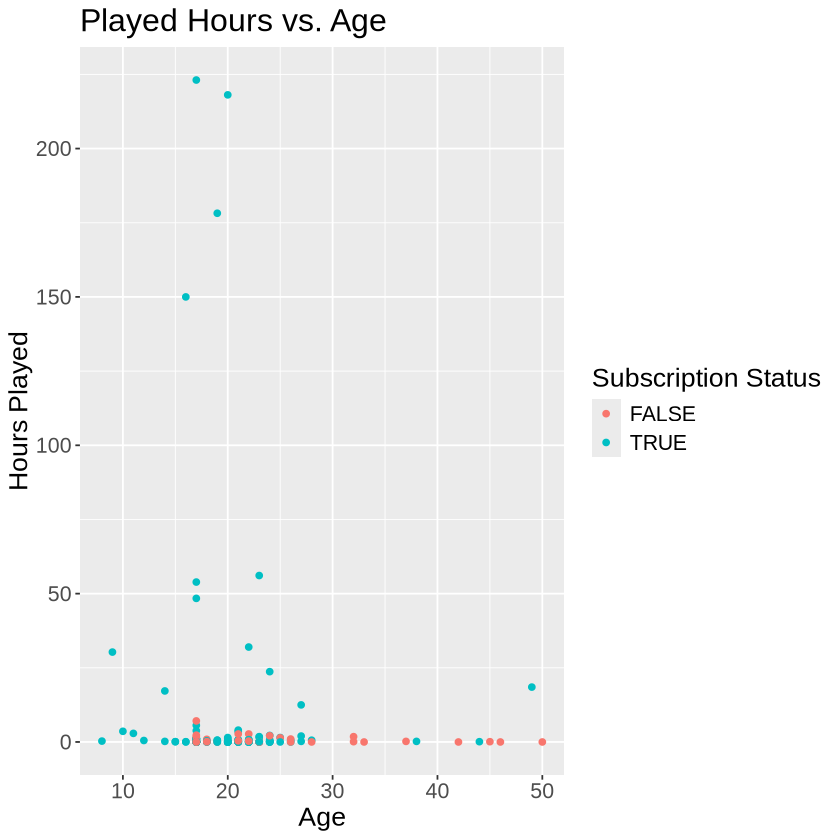

In [9]:
age_vs_hours_plot <- players_simplified |>
    ggplot(aes(x = age, y = played_hours, colour = subscribe)) +
        geom_point() +
        labs(x = 'Age',
             y = 'Hours Played',
             colour = 'Subscription Status',
             title = 'Played Hours vs. Age') +
             theme(text = element_text(size = 16))

age_vs_hours_plot

## BOTH PREDICTORS

In [10]:
set.seed(2000)
players_simplified <- players_simplified |>
    mutate(subscribe = as_factor(subscribe))

players_split <- initial_split(players_simplified, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

In [11]:
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

Chose to do 3 folds instead of 5 because was having error due to not enough cases from each case (subscribed / not subscribed) with 5

In [12]:
players_vfold <- vfold_cv(players_train, v = 3, strata = subscribe)

In [13]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

Chose to test 20 neighbours because graph peaked at around this number

In [14]:
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

players_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics() |>
      filter(.metric == "accuracy")

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 47 rows.
               ✖ Assigned data has 49 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 49 to size 47.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





In [15]:
neighbours_plot <- players_results |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of Neighbours", y = "Accuracy", title = "Accuracy vs. Neighbours") +
        scale_x_continuous(breaks = seq(0, 20, by = 2))

In [16]:
knn_spec_predict <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_predict) |>
    fit(data = players_train)

In [17]:
players_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)

players_predictions

players_metrics <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_metrics

.pred_class,age,subscribe,played_hours
<fct>,<dbl>,<fct>,<dbl>
TRUE,22,TRUE,0.0
TRUE,23,TRUE,1.6
TRUE,17,TRUE,0.0
⋮,⋮,⋮,⋮
TRUE,17,FALSE,1.7
FALSE,44,TRUE,0.1
TRUE,17,FALSE,0.0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


## HOURS PREDICTOR

In [18]:
set.seed(2000)
players_recipe_hours <- recipe(subscribe ~ played_hours, data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

In [19]:
players_results_hours <- workflow() |>
      add_recipe(players_recipe_hours) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics() |>
      filter(.metric == "accuracy")

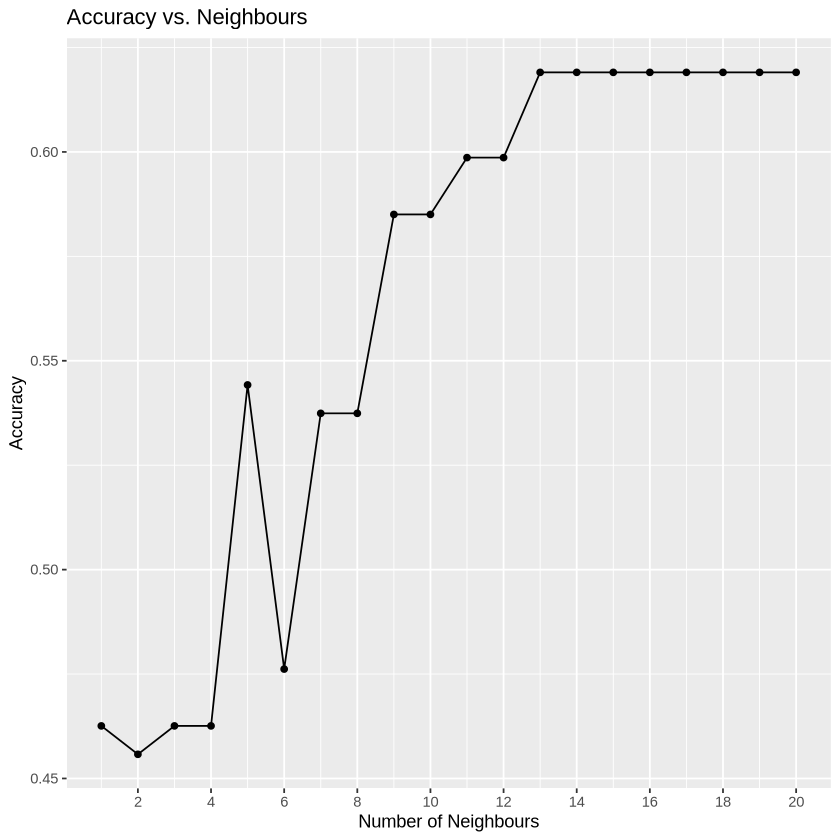

In [20]:
neighbours_plot_hours <- players_results_hours |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of Neighbours", y = "Accuracy", title = "Accuracy vs. Neighbours") +
        scale_x_continuous(breaks = seq(0, 20, by = 2))

neighbours_plot_hours

In [21]:
knn_spec_predict_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit_hours <- workflow() |>
    add_recipe(players_recipe_hours) |>
    add_model(knn_spec_predict_hours) |>
    fit(data = players_train)

In [22]:
players_predictions_hours <- predict(players_fit_hours, players_test) |>
    bind_cols(players_test)

players_metrics_hours <- players_predictions_hours |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_metrics_hours

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4489796


## AGE PREDICTOR

In [23]:
set.seed(2000)
players_recipe_age <- recipe(subscribe ~ age, data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

In [24]:
players_results_age <- workflow() |>
      add_recipe(players_recipe_age) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics() |>
      filter(.metric == "accuracy")

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 47 rows.
               ✖ Assigned data has 49 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 49 to size 47.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





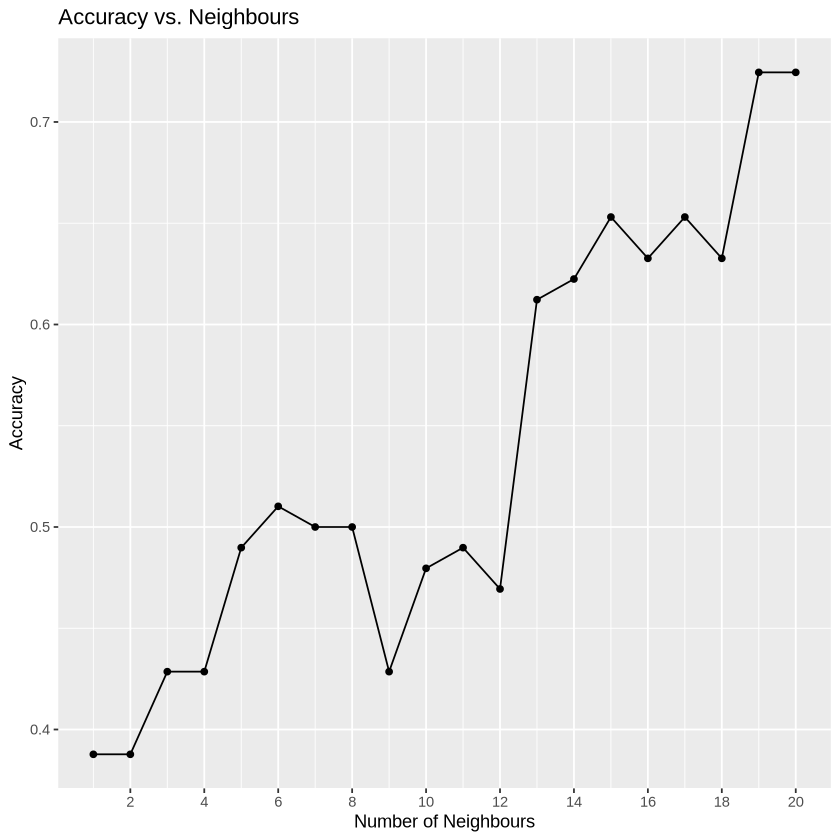

In [25]:
neighbours_plot_age <- players_results_age |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of Neighbours", y = "Accuracy", title = "Accuracy vs. Neighbours") +
        scale_x_continuous(breaks = seq(0, 20, by = 2))

neighbours_plot_age

In [26]:
knn_spec_predict_age <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit_age <- workflow() |>
    add_recipe(players_recipe_age) |>
    add_model(knn_spec_predict_age) |>
    fit(data = players_train)

In [27]:
players_predictions_age <- predict(players_fit_age, players_test) |>
    bind_cols(players_test)

players_metrics_age <- players_predictions_age |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_metrics_age

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6122449


# Discussion

Through the classification model, we found that using both predictors (`played_hours` and `age`) yielded the highest accuracy, around 71.43%. The individual `played_hours` and `age` predictors achieved an accuracy of around 61.22% and 44.90%, respectively.  The low accuracy of the `played_hours` predictor suggests it was not able to learn a relationship and performed worse than randomly guessing. In contrast when combining the two predictors, the $k$-NN model was able to learn the trends/patterns for an improved performance. 

We anticipated that `played_hours` and `age` would individually contribute to predicting the newsletter subscription status. However, the results showed that `played_hours` was not a reliable predictor due to its low accuracy, which was unexpected. Combining the two variables yields the highest accuracy. That was also unexpected as there did not seem to have a clear pattern when observing the visualizations, especially the scatterplot with both predictors.

These findings can impact marketing strategies to improve newsletter subscriptions, player engagement and retention. By understanding that the relationship between players’ age and hours played can predict their newsletter subscription, there can be targeted marketing as a result. Flyers and campaigns can be customized to appeal to and attract certain age groups with specific gaming behaviours. Thus, increasing the overall player engagement and subscription numbers.

A future question that this research could lead to can be, what other variables can be involved to predict the newsletter subscription status of players such as in-game purchases. It can also lead to inferential questions such as why do age and amount of hours play influence the newsletter subscription status? Could it be due to psychological or environmental reasons? 